<a href="https://colab.research.google.com/github/Soumyajit567/Advance_House_Price_Prediction/blob/master/Sentimental_Analysis_from_text_and_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from google.colab import drive
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

**Importing and Analyzing the Dataset.**

Let's now import and analyze our dataset. Execute the following script:


In [5]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [10]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")
movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

 Above we use the read_csv() method of the pandas library to read the CSV file containing our dataset. In the next line, we check if the dataset contains any NULL value or not. Finally, we print the shape of our dataset.
 

Let's now print the first 5 rows of the dataset using the head() method.

In [11]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Let's now take a look at any one of the reviews
.

In [12]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

**Finally, let's see the distribution of positive and negative sentiments in our dataset.**


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


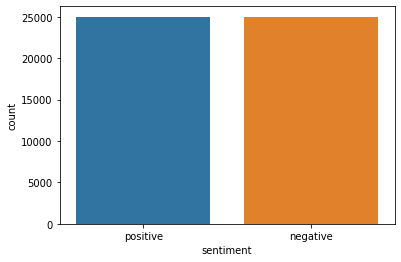

In [13]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

From the output, it is clear that the dataset contains equal number of positive and negative reviews

**Data Preprocessing**

We saw that our dataset contained punctuations and HTML tags. In this section we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters and HTML tags from the string. Finally, the string is returned to the calling function. Look at the following script:

In [14]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [15]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In the preprocess_text() method the first step is to remove the HTML tags. To remove the HTML tags, remove_tags() function has been defined. The remove_tags function simply replaces anything between opening and closing <> with an empty space.

Next, in the preprocess_text function, everything is removed except capital and small English letters, which results in single characters that make no sense. For instance, when you remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s".

Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

Next, we will preprocess our reviews and will store them in a new list as shown below:

In [16]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

**Let's now again see the fourth review:**

In [17]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

**From the output, you can see that the HTML tags, punctuations and numbers have been removed. We are only left with the alphabets.**

**Next, we need to convert our labels into digits. Since we only have two labels in the output i.e. "positive" and "negative"**.

We can simply convert them into integers by replacing "positive" with digit 1 and negative with digit 0 as shown below: 

In [18]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

**Finally, we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.**

We can use train_test_split method from the sklearn.model.selection module, as shown below:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

The script above divides our data into 80% for the training set and 20% for the testing set.

Let's now write the script for our embedding layer. The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras.

**Preparing the Embedding Layer**

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. Execute the following script:

In [20]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

If you view the X_train variable in variable explorer, you will see that it contains 40,000 lists where each list contains integers. Each list actually corresponds to each sentence in the training set. You will also notice that the size of each list is different. This is because sentences have different lengths.

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

The following script finds the vocabulary size and then perform padding on both train and test set.

In [21]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

**Now if you view the X_train or X_test, you will see that all the lists have same length i.e. 100. Also, the vocabulary_size variable now contains a value 92547 which means that our corpus has 92547 unique words.**

We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [28]:
uploading = files.upload()


Saving glove.6B.100d.txt to glove.6B.100d.txt


In [31]:

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

**Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.**

In [32]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Once you execute the above script, you will see that embedding_matrix will contain 92547 rows (one for each word in the corpus). Now we are ready to create our deep learning models.

**Text Classification with Simple Neural Network**


The first deep learning model that we are going to develop is a simple deep neural network. Look at the following script: 

In [33]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In the script above, we create a Sequential() model. Next, we create our embedding layer. The embedding layer will have an input length of 100, the output vector dimension will also be 100. The vocabulary size will be 92547 words. Since we are not training our own embeddings and using the GloVe embedding, we set trainable to False and in the weights attribute we pass our own embedding matrix.

The embedding layer is then added to our model. Next, since we are directly connecting our embedding layer to densely connected layer, we flatten the embedding layer. Finally, we add a dense layer with sigmoid activation function.

To compile our model, we will use the adam optimizer, binary_crossentropy as our loss function and accuracy as metrics and then we will print the summary of our model:

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


**Since there are 92547 words in our corpus and each word is represented as a 100-dimensional vector, the number of trainable parameter will be 92547x100 in the embedding layer. In the flattening layer, we simply multiply rows and column. Finally in the dense layer the number of parameters are 10000 (from the flattening layer) and 1 for the bias parameter, for a total of 10001.**

Let's now train our model:

In [35]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 5ms/step - loss: 0.6044 - acc: 0.6663 - val_loss: 0.5327 - val_acc: 0.7364
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4963 - acc: 0.7596 - val_loss: 0.5182 - val_acc: 0.7389
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4613 - acc: 0.7828 - val_loss: 0.5174 - val_acc: 0.7442
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4358 - acc: 0.8013 - val_loss: 0.5221 - val_acc: 0.7462
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4200 - acc: 0.8108 - val_loss: 0.5544 - val_acc: 0.7290
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4115 - acc: 0.8140 - val_loss: 0.5362 - val_acc: 0.7418


**In the scipt above, we use the fit method to train our neural network. Notice we are training on our train set only. The validation_split of 0.2 means that 20% of the training data is used to find the training accuracy of the algorithm.**

**At the end of the training, you will see that training accuracy is around 85.52%.**

To evaluate the performance of the model, we can simply pass the test set to the evaluate method of our model.

In [36]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.5388 - acc: 0.7437


**To check the test accuracy and loss, execute the following script:**

In [37]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5388320684432983
Test Accuracy: 0.7437000274658203


**Once you execute the above script, you will see that we get a test accuracy of 74.68%. Our training accuracy was 85.52%. This means that our model is overfitting on the training set. Overfitting occurs when your model performs better on the training set than the test set. Ideally, the performance difference between training and test sets should be minimum.**

Let's try to plot the loss and accuracy differences for training and test sets. Execute the following script:

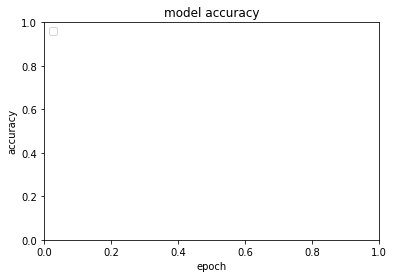

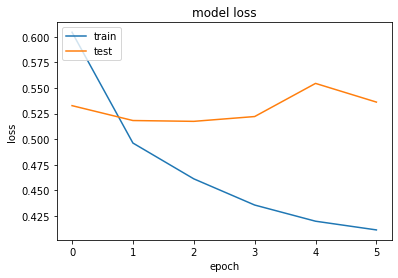

In [39]:
import matplotlib.pyplot as plt
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Text Classification with a Convolutional Neural Network**

Convolutional neural network is a type of network that is primarily used for 2D data classification, such as images. A convolutional network tries to find specific features in an image in the first layer. In the next layers, the initially detected features are joined together to form bigger features. In this way, the whole image is detected.

Convolutional neural networks have been found to work well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. To learn more about convolutional neural networks, please refer to this article.

Let's create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer. Remember, the code up to the creation of the embedding layer will remain same, execute the following piece of code after you create the embedding layer:

In [44]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

**In the above script we create a sequential model, followed by an embedding layer. This step is similar to what we had done earlier. Next, we create a one-dimensional convolutional layer with 128 features, or kernels. The kernel size is 5 and the activation function used is sigmoid. Next, we add a global max pooling layer to reduce feature size. Finally we add a dense layer with sigmoid activation. The compilation process is the same as it was in the previous section.**

Let's now see the summary of our model:

In [45]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


**You can see that in the above case we don't need to flatten our embedding layer. You can also notice that feature size is now reduced using the pooling layer.**

*Let's now train our model and evaluate it on the training set. The process to train and test our model remains the same. To do so, we can use the fit and evaluate methods, respectively.*

In [46]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 2s 9ms/step - loss: 0.5116 - acc: 0.7423 - val_loss: 0.4165 - val_acc: 0.8087
Epoch 2/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3785 - acc: 0.8316 - val_loss: 0.3758 - val_acc: 0.8291
Epoch 3/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3244 - acc: 0.8616 - val_loss: 0.3616 - val_acc: 0.8361
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2847 - acc: 0.8839 - val_loss: 0.3728 - val_acc: 0.8304
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2514 - acc: 0.9020 - val_loss: 0.3505 - val_acc: 0.8445
Epoch 6/6
313/313 [==============================] - 1s 3ms/step - loss: 0.3405 - acc: 0.8485


*The following script prints the results:*

In [47]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.34046363830566406
Test Accuracy: 0.8485000133514404


**If you compare the training and test accuracy, you will see that the training accuracy for CNN will be around 92%, which is greater than the training accuracy of the simple neural network. The test accuracy is around 82% for the CNN, which is also greater than the test accuracy for the simple neural network, which was around 74%.**

*However our CNN model is still overfitting as there is a vast difference between the training and test accuracy. Let's plot the loss and accuracy difference between the training and test set.*

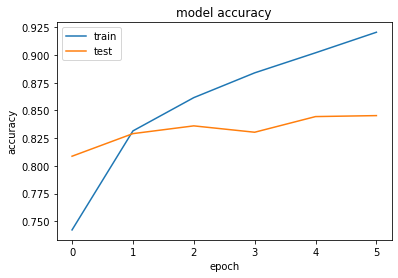

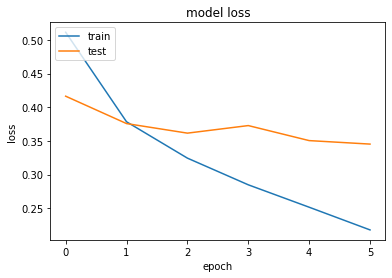

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

You can clearly see the loss and accuracy differences between train and test sets.

Let's now train our third deep learning model, which is a recurrent neural network, and see if we can get rid of the overfitting.  

**Text Classification with Recurrent Neural Network (LSTM)**

Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. In this section, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve sentiment classification problem.

Once again, execute the code until the word embedding section and after that run the following piece of code.

In [50]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

**In the script above, we start by initializing a sequential model followed by the creation of the embedding layer. Next, we create an LSTM layer with 128 neurons (You can play around with number of neurons). The rest of the code is same as it was for the CNN.**

Let's plot the summary of our model.

In [51]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


*Our next step is to train the model on the training set and evaluate its performance on the test set.*

In [52]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 9s 37ms/step - loss: 0.5483 - acc: 0.7143 - val_loss: 0.4423 - val_acc: 0.7906
Epoch 2/6
250/250 [==============================] - 8s 33ms/step - loss: 0.4380 - acc: 0.7967 - val_loss: 0.4018 - val_acc: 0.8139
Epoch 3/6
250/250 [==============================] - 8s 32ms/step - loss: 0.4059 - acc: 0.8155 - val_loss: 0.4054 - val_acc: 0.8166
Epoch 4/6
250/250 [==============================] - 8s 32ms/step - loss: 0.3764 - acc: 0.8317 - val_loss: 0.3534 - val_acc: 0.8420
Epoch 5/6
250/250 [==============================] - 8s 31ms/step - loss: 0.3478 - acc: 0.8471 - val_loss: 0.3419 - val_acc: 0.8484
Epoch 6/6
313/313 [==============================] - 3s 8ms/step - loss: 0.3526 - acc: 0.8426


**The script above trains the model on the test set. The batch size is 128, whereas the number of epochs is 6. At the end of the training, you will see that the training accuracy is around 85.40%.**

*Once the model is trained, we can see the model results on test set with the following script:*

In [53]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3525768220424652
Test Accuracy: 0.8425999879837036


**In the output, you will see that our test accuracy is around 85.04%. The test accuracy is better than both the CNN and densely connected neural network. Also, we can see that there is a very small difference between the training accuracy and test accuracy which means that our model is not overfitting.**

Let's plot the loss and accuracy differences between training and test sets. 

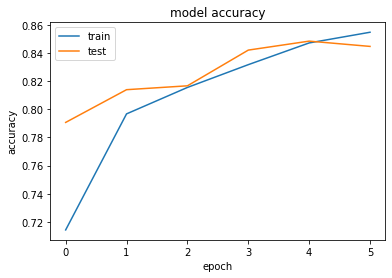

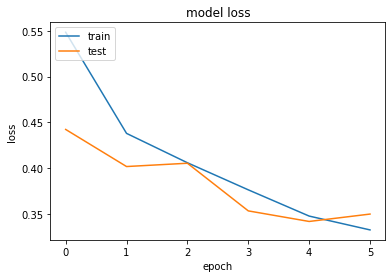

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**The output shows that the difference between the accuracy values for training and test sets is much smaller compared to the simple neural network and CNN. Similarly, the different between the loss values is also negligible, which shows that our model is not overfitting. We can conclude, that for our problem, RNN is the best algorithm.**

*In this article, we randomly chose the number of layers, neurons, hyper parameters, etc. I would suggest that you try to change the number of layers, number of neurons and activation functions for all three neural networks discussed in this article and see which neural network works best for you.*

**Making Predictions on Single Instance**

This is the final section of the article and here we will see how to make predictions on a single instance or single sentiment. Let's retrieve any review from our corpus and then try to predict its sentiment.

Let's first randomly select any review from our corpus:

In [55]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


**You can clearly see that this is negative review. To predict the sentiment of this review, we have to convert this review into numeric form. We can do so using the tokenizer that we created in word embedding section. The text_to_sequences method will convert the sentence into its numeric counter part.**

Next, we need to pad our input sequence as we did for our corpus. Finally, we can use the predict method of our model and pass it our processed input sequence. Look at the following code:

In [56]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.27955768]], dtype=float32)

***Remember, we mapped the positive outputs to 1 and the negative outputs to 0. However, the sigmoid function predicts floating value between 0 and 1. If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive. The sentiment value for our single instance is 0.33 which means that our sentiment is predicted as negative, which actually is the case.***

**Conclusion**

Text classification is one of the most common natural language processing tasks. In this article we saw how to perform sentiment analysis, which is a type of text classification using Keras deep learning library. We used three different types of neural networks to classify public sentiment about different movies. The results show that LSTM, which is a variant of RNN outperforms both the CNN and simple neural network.